# Canada Crop Yield Predictor

### Objective:

This project aimed to forecast crop yields of major crops across different provinces in Canada using advanced data analysis techniques, benefiting farmers and policymakers in planning agricultural activities. The model takes temperature extremes, snow depth, precipitation levels, longitude and latitude into consideration.

###Collecting and Preparing Data:


- Historical yields are collected and collated by Statistics Canada on an annual basis based upon Census Agricultural Regions (CAR’s) from year 1987 to 2022 and the organized dataset consisted of 36288 rows of data.
- Climate data was collected from the public dataset created by the National Oceanic and Atmospheric Administration (NOAA) and includes global data obtained from the USAF Climatology Center.
- This dataset contains daily summaries of weather data obtained from over 9000 weather stations, and the BigQuery Python client library was used to query tables.
- Extracted daily weather data from the year 1987 to 2024 by calculating yearly averages of the temperature extremes, snow depth, and precipitation levels.
- This data was carefully cleaned and organized to ensure accuracy, removing any inconsistencies or missing information.










## Import Libraries

In [3]:
# Import packages
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Crop Yield'
import pandas as pd
import numpy as np
import datetime as dt
from dateutil import rrule
from datetime import datetime, timedelta

#!pip install env_canada
#!pip install  nest_asyncio
#!pip install func
!pip install geodatasets
!pip install geopandas
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import asyncio
#from env_canada.ec_historical import ECHistoricalRange, get_historical_stations
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Crop Yield


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Data Extraction

## Yield Data

Canadian Crop Yields is a series of datasets including historical yields and in-season yield forecasts for major field crops in Canada. Historical yields are
collected by Statistics Canada on an annual basis based upon Census Agricultural Regions.

Link of the dataset used - https://open.canada.ca/data/en/dataset/9253a01b-f1d9-4b67-ba98-857667827c7b

14 Crop types are considered for the model.

Bushels per Acre (bu/ac)

* Barley
* Canola
* Corn for Grain
* Dry Pea
* Durum Wheat
* Flax
* Oats
* Soybeans
* Spring Wheat
* Winter Wheat


Pounds per Acre (lbs/ac)
* Lentil



In [2]:
# Read the csv file from google drive  named historical_actual_crop_yield_by_CAR.csv

yield_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crop Yield/historical_actual_crop_yield_by_CAR.csv')

print(yield_df.head())

# Get unique CROP list

unique_crop_list = yield_df['CROP'].unique().tolist()
# Get the uique LATITUDE and LONGITUDE from df and create a list of the unique LATITUDE and LONGITUDE in a list

lat_long = list(set(zip(yield_df['LATITUDE'], yield_df['LONGITUDE'])))
# Loop through lat_long and assign the latitude and longitute to a variable and add them to a list

cord_list = []
for latitude, longitude in lat_long:
  coordinate = [f"{latitude}",f"{longitude}"]
  cord_list.append(coordinate)


#get the unique CARUID list
uid_list = yield_df.CARUID.unique()

   CARUID         CROP  Y1987  Y1988  Y1989  Y1990  Y1991  Y1992  Y1993  \
0    1001       barley -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
1    1001  canary_seed -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
2    1001       canola -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
3    1001         corn -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
4    1001  durum_wheat -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   

   Y1994  ...  Y2015  Y2016  Y2017  Y2018  Y2019  Y2020  Y2021  Y2022  \
0 -999.0  ... -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
1 -999.0  ... -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
2 -999.0  ... -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
3 -999.0  ... -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
4 -999.0  ... -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   

    LATITUDE  LONGITUDE  
0  47.347472 -54.072387  
1  47.347472 -54.072387  
2  47.347472 -54.072387  
3  47.

### Structuring the dataset to analyze

In [ ]:
# Stack all the columns

stacked_df = yield_df[yield_df['CARUID'] ==uid_list[0]].transpose().stack().reset_index(name='value')

stacked_df.columns = ['year', 'crop', 'value']
#Get the crop names
crop_list = yield_df[yield_df['CARUID'] ==uid_list[0]]['CROP']
#Convert this to a dataframe and repeat for all the CARUID
df_1 = yield_df[yield_df['CARUID'] ==uid_list[0]].transpose()[2:-2].stack().reset_index(name='value')
df_1.columns = ['year', 'crop', 'value']
for i in range(len(df_1)):
    df_1['crop'][i]= crop_list[df_1['crop'][i]]
    df_1['CARUID'] = np.full(len(df_1), uid_list[0])
    df_1['lat'] = np.full(len(df_1), cord_list[0][0])
    df_1['long'] = np.full(len(df_1), cord_list[0][1])



#loop through all the CAARUID's and create a dataframe
# Initialize an empty list to store individual data frames
df_list = []

# Loop through the CAR UID list
for uid in uid_list:


    crop_list = yield_df[yield_df['CARUID'] ==uid]['CROP']
    # Apply your code to filter data for the current UID
    df_1 = yield_df[yield_df['CARUID'] == uid].transpose()[2:-2].stack().reset_index(name='value')
    df_1.columns = ['year', 'crop', 'value']

    for i in range(len(df_1)):
      df_1['crop'][i]= crop_list[df_1['crop'][i]]
    df_1['CARUID'] = np.full(len(df_1), uid_list[0])
    df_1['lat'] = np.full(len(df_1), cord_list[0][0])
    df_1['long'] = np.full(len(df_1), cord_list[0][1])


    # Append the resulting dataframe to the list
    df_list.append(df_1)

# Concatenate all dataframes in df_list into a single dataframe
output_df = pd.concat(df_list, ignore_index=True)


output_df['year'] = output_df['year'].str[1:]
output_df['year'] = output_df['year'].astype(int)

output_df.rename(columns={'value':'yield'}, inplace=True)
output_df['lat'] = output_df['lat'].astype(float)
output_df['long'] = output_df['long'].astype(float)


# Save the output dataframe to a CSV file
output_df.to_csv('output.csv', index=False)

# Get a dataframe with unique CARUID and add the lat and the long of it as another two columns

unique_car_df = pd.DataFrame(uid_list, columns=['CARUID'])
unique_car_df['lat'] = [x[0] for x in cord_list]
unique_car_df['long'] = [x[1] for x in cord_list]

output_df.head()

,year,crop,yield,CARUID,lat,long
0,1987,barley,-999.0,1001,49.630005,-96.804104
1,1987,canary_seed,-999.0,1001,49.630005,-96.804104
2,1987,canola,-999.0,1001,49.630005,-96.804104
3,1987,corn,-999.0,1001,49.630005,-96.804104
4,1987,durum_wheat,-999.0,1001,49.630005,-96.804104



**This dataframe contains historical crop yield dataset from year 1987 to year 2022.**

Description of the columns of the table

- yield	- Historical crop yield provided by Statistics Canada
- CARUID - Census Agriculture Region

There are 36288 rows and 6 columns namely
1. year
2. crop
3. yield
4. CARUID
5. lat
6. long

## Weather Data From climate.weather.gc.ca

Link for the database - https://climate.weather.gc.ca/historical_data/search_historic_data_e.html

- This provides daily weather data from different station locations.
- Daily weather data can be filtered by providing a longitude, latitude and a date range.
- This database was selected because of the option to get weather data using longitude and latitude from multiple weather stations by providing a distance to select multiple weather station data within the given longitude and latitude.

In [ ]:
def getData(stationID, year, month):
    """
    This function retrieves weather data for a given station, year, and month.

    Args:
        stationID (str): The ID of the weather station.
        year (int): The year for which to retrieve data.
        month (int): The month for which to retrieve data.

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the weather data.
    """
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=2".format(stationID, year, month)
    api_endpoint = base_url + query_url
    return pd.read_csv(api_endpoint, skiprows=0)

def getData_btween_dates(stationID, start_date, end_date ):
    """
    This function retrieves weather data for a given station between two dates.

    Args:
        stationID (str): The ID of the weather station.
        start_date (datetime.date): The start date for the data retrieval.
        end_date (datetime.date): The end date for the data retrieval.

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the weather data.
    """
    frames = []
    for dt_i in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
        df = getData(stationID, dt_i.year, dt_i.month)
        frames.append(df)

    weather_data = pd.concat(frames)
    weather_data.reset_index(inplace=True)
    weather_data['Date/Time'] = [pd.to_datetime(weather_data['Date/Time'][i]).date() for i in range(len(weather_data))]

    return weather_data

In [ ]:

def data_extract(coordinates,start,end):
    """
    This function extracts weather data for a given location and time period.

    Args:
      coordinates (tuple): A tuple containing the latitude and longitude of the location.
      start (datetime.date): The start date for the data retrieval.
      end (datetime.date): The end date for the data retrieval.

    Returns:
      pd.DataFrame: A Pandas DataFrame containing the weather annualized data.
    """

    stations = pd.DataFrame(asyncio.run(get_historical_stations(coordinates, start_year=start.year,
                                                    end_year=end.year, radius=50, limit=100))).T
    stations.reset_index(inplace=True)
    station_count = len(stations)
    if station_count==0:
      return pd.DataFrame(columns=['year', 'snow', 'rain', 'precip',
                                   'max_temp', 'min_temp', 'lat','long'])
    for i in range(station_count):
      station_id = stations['id'][i]
      df_temp =  getData_btween_dates(station_id, start, end )
      df_temp = df_temp[['Date/Time','Mean Temp (°C)', 'Total Snow (cm)', 'Total Precip (mm)', 'Total Rain (mm)',
                        'Max Temp (°C)', 'Min Temp (°C)', ]]
      df_temp.columns = [f'{i}_Date/Time', f'{i}_mean_temp', f'{i}_snow', f'{i}_precip', f'{i}_rain',
                        f'{i}_max_temp', f'{i}_min_temp']

      if i ==0:
        df = df_temp
      else:
        df = pd.concat([df,df_temp], axis=1)

    df_anual= pd.DataFrame()
    #print(df.columns)
    df_anual['date'] = df['0_Date/Time']
    col_list = ['mean_temp', 'snow', 'precip', 'rain', 'max_temp', 'min_temp']
    for col in col_list:
      df_anual[col] = np.mean(df[[f'{i}_{col}' for i in range(station_count)]], axis=1)

    df_anual['year'] = [df_anual.date[i].year
                        if df_anual.date[i].month<10
                        else df_anual.date[i].year+1
                        for i in range(len(df_anual))]
    df_final = pd.DataFrame()
    df_final['snow']= df_anual.groupby('year')['snow'].sum()
    df_final['rain']= df_anual.groupby('year')['rain'].sum()
    df_final['precip']= df_anual.groupby('year')['precip'].sum()
    df_final['max_temp']= df_anual.groupby('year')['max_temp'].max()
    df_final['min_temp']= df_anual.groupby('year')['min_temp'].min()
    df_final.reset_index(inplace=True)
    df_final['lat'] = np.full(len(df_final), coordinates[0])
    df_final['long'] = np.full(len(df_final), coordinates[1])
    return df_final

In [ ]:
### DO NOT RUN THIS CODE LINE UNLESS THIS IS THE FIRST TIME RUNNNG THE CODE
with open('index.txt', 'w') as f:
  f.write('0')

In [ ]:
"""
 This code snippet is used to extract weather data for multiple locations and time periods.
 It uses the `data_extract` function to retrieve weather data for a given location and time period,
 and then combines the data into a single DataFrame.
"""
cord_list = [['48.508333', '-68.467667'],['53.837090',	'-60.961935'],['46.212217',	'-63.114662	'],['57.073600',	'-128.483473'	],['44.109156798862365','-65.31218993670555']]

# Read the current index from the 'index.txt' file.
# This file keeps track of the last processed location index.
with open('index.txt', 'r') as f:
  lines = f.read()
start = int(lines)
# If the start index is greater than 0, it means that the code has been run before and there is existing weather data.
if start>0:
  # Read the existing weather data from the 'weather_data.csv' file.
  test_data_new = pd.read_csv('weather_data.csv')

# Set the start and end dates for the weather data retrieval.
start_date = datetime.strptime('Jan2015', '%b%Y')
end_date = datetime.strptime('Dec2020', '%b%Y')

# Loop through the remaining locations in the `cord_list`.
for i in range(start,len(cord_list)):
  # Update the index file with the current location index.
  with open('index.txt', 'w') as f:
    f.write(f'{i}')
   # If this is the first location being processed, extract the weather data and save it to a new CSV file.
  if i ==0:
    test_data_new = data_extract(cord_list[i],start_date , end_date)
    test_data_new.to_csv('weather_data.csv')
  # For subsequent locations, extract the weather data and append it to the existing DataFrame.
  else:
    test_data_temp= data_extract(cord_list[i],start_date , end_date)
    test_data_new = pd.concat([test_data_new,test_data_temp])
    test_data_new.to_csv('weather_data.csv')


In [ ]:

# This list contains the coordinates of the locations for which weather data needs to be extracted.
cord_list = [['48.508333', '-68.467667'],['53.837090',	'-60.961935'],['46.212217',	'-63.114662	'],['57.073600',	'-128.483473'	],['44.109156798862365','-65.31218993670555']]

# Read the current index from the file.
with open('index.txt', 'r') as f:
  lines = f.read()
start = int(lines)

# If the index is greater than 0, read the existing weather data from the CSV file.
if start>0:
  test_data_new = pd.read_csv('weather_data.csv')

# Set the start and end dates for the weather data extraction.
start_date = datetime.strptime('Jan2015', '%b%Y')
end_date = datetime.strptime('Dec2020', '%b%Y')

# Loop through the remaining locations in the list.
for i in range(start,len(cord_list)):
  # Update the index file with the current index.
  with open('index.txt', 'w') as f:
    f.write(f'{i}')

  # If this is the first location, extract the weather data and save it to the CSV file.
  if i ==0:
    test_data_new = data_extract(cord_list[i],start_date , end_date)
    test_data_new.to_csv('weather_data.csv')
  # Otherwise, extract the weather data for the current location and append it to the existing data in the CSV file.
  else:
    test_data_temp= data_extract(cord_list[i],start_date , end_date)
    test_data_new = pd.concat([test_data_new,test_data_temp])
    test_data_new.to_csv('weather_data.csv')


In [ ]:
test_data_new

## Bigquery Data Extract

I used the public dataset created by the National Oceanic and Atmospheric Administration (NOAA), which includes global data obtained from the USAF Climatology Center for weather data extraction. This dataset covers GSOD data between 1929 and the present, collected from over 9000 stations.

The daily elements included in the dataset (as available from each station) are:

- Mean temperature (.1 Fahrenheit)
- Mean dew point (.1 Fahrenheit)
- Mean sea level pressure (.1 mb)
- Mean station pressure (.1 mb)
- Mean visibility (.1 miles)
- Mean wind speed (.1 knots)
- Maximum sustained wind speed (.1 knots)
- Maximum wind gust (.1 knots)
- Maximum temperature (.1 Fahrenheit)
- Minimum temperature (.1 Fahrenheit)
- Precipitation amount (.01 inches)
- Snow depth (.1 inches)

###Querying BigQuery tables

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Crop Yield'
import os
import pandas as pd
from urllib.request import urlopen
import json
#from pandas.io.json import json_normalize
from io import StringIO
from tabulate import tabulate
import numpy as np
import datetime as dt
import csv
import math
import requests
import matplotlib as mp
import func as fc
import matplotlib.pyplot as plt
import datetime
#!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
from google.cloud import bigquery
#from google.colab import files
#uploaded = files.upload()

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Crop Yield


In [4]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='key.json'
client = bigquery.Client()
trans_ref = client.get_table('bigquery-public-data.noaa_gsod.gsod1929')
fc.get_atts(trans_ref)


['clone_definition',
 'clustering_fields',
 'created',
 'dataset_id',
 'description',
 'encryption_configuration',
 'etag',
 'expires',
 'external_data_configuration',
 'friendly_name',
 'from_api_repr',
 'from_string',
 'full_table_id',
 'labels',
 'location',
 'modified',
 'mview_enable_refresh',
 'mview_last_refresh_time',
 'mview_query',
 'mview_refresh_interval',
 'num_bytes',
 'num_rows',
 'partition_expiration',
 'partitioning_type',
 'path',
 'project',
 'range_partitioning',
 'reference',
 'require_partition_filter',
 'schema',
 'self_link',
 'snapshot_definition',
 'streaming_buffer',
 'table_constraints',
 'table_id',
 'table_type',
 'time_partitioning',
 'to_api_repr',
 'to_bqstorage',
 'view_query',
 'view_use_legacy_sql']

The blow function dynamically constructs a SQL query to retrieve weather data from a database for stations located within 50 kilometers of the specified coordinates.








In [6]:

def weather_data(cord_list):
    """
    Constructs a SQL query string to retrieve weather data from a database for stations located within 50 kilometers
    of the specified coordinates.

    Parameters:
    - cord_list (list): A list of coordinate pairs (latitude and longitude) specifying the locations of interest.

    Returns:
    - str: A SQL query string.

    Explanation:
    This function generates a SQL query string for retrieving weather data from a database based on a list of coordinates.
    It constructs the query to select all columns from the 'bigquery-public-data.noaa_gsod.stations' table, filtering
    stations located in Canada ('COUNTRY = 'CA'') and within 50 kilometers of each specified coordinate. The distance
    calculation is performed using the 'ST_Distance' function, which computes the distance between two points represented
    by their longitude and latitude coordinates. The coordinates from 'cord_list' are dynamically inserted into the query
    string. The resulting SQL query string is returned for further execution.

    """

    str1 = f"""
    SELECT *
    FROM `bigquery-public-data.noaa_gsod.stations`
    WHERE COUNTRY = 'CA' AND
   (ST_Distance(ST_GeogPoint(lon, lat), ST_GeogPoint({cord_list[0][1]},{cord_list[0][0]})) <= 50000
    """
    for i in range(1,len(cord_list)):
      str2 = f"""
            OR
            ST_Distance(ST_GeogPoint(lon, lat), ST_GeogPoint({cord_list[i][1]},{cord_list[i][0]})) <= 50000
      """
      if i ==1:
        tem_str = str1+ str2
      else:
        tem_str += str2
    str3 = """
          )
    ;
    """
    str_4 = tem_str+str3
    return str_4

In [7]:
station_query = weather_data(cord_list)
station_table = client.query(station_query).to_dataframe()
station_table.to_csv('station_data.csv')
station_table.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,710011,99999,CALLAGHAN VALLEY (SKI JUMP TO,CA,None,CVOW,50.133,-123.117,+0936.0,20070228,20100413
1,710021,99999,CALLAGHAN VALLEY(SKI JUMP BOT,CA,None,None,50.133,-123.117,+0860.0,20090101,20100623
2,710031,99999,CALLAGHAN VALLEY(BIATHALON),CA,None,CVOY,50.150,-123.117,+0870.0,20070306,20100708
3,710268,99999,HOWICK,CA,None,None,45.167,-73.867,+0042.0,20040921,20070614
4,710361,99999,RUISSEAU CRANBERRY,CA,None,None,45.117,-73.667,+0059.0,20040921,20070614


In [ ]:
"""
    Constructs a SQL query to retrieve weather data from the Google BigQuery dataset 'bigquery-public-data.noaa_gsod',
    filtering stations based on their unique codes.

    Parameters:
    - station_table (DataFrame): A DataFrame containing weather station information, including station codes.

    Returns:
    - str: A SQL query string for retrieving weather data.

    Explanation:
    This function constructs a SQL query to fetch weather data from the 'bigquery-public-data.noaa_gsod' dataset in
    Google BigQuery. First, it extracts unique station codes from the 'usaf' column of the provided 'station_table'
    DataFrame and converts them into a list.

    The constructed SQL query selects various weather parameters (such as station code, year, month, day,
    precipitation, snow depth, maximum temperature, and minimum temperature) from a combination of GSOD (Global Surface
    Summary of the Day) tables. It applies unit conversions for certain parameters, converting precipitation and snow
    depth from inches to centimeters, and temperature from Fahrenheit to Celsius.

    The subquery within the SQL query retrieves data from GSOD tables using a wildcard ('gsod*') to join all tables,
    filtering tables with suffixes between '1987' and '2024' to include data from 1987 to 2024. The outer query then
    filters the results based on the station codes present in the 'station_list', treating the list as an array of
    values using the UNNEST() function.

"""

station_list  =list(set(station_table["usaf"]))
query = f"""

SELECT
    stn,
    year,
    mo,
    da,
    prcp * 2.54 AS prcp_cm,
    sndp * 2.54 AS sndp_cm,
    (max - 32) * 5/9 AS max_celsius,
    (min - 32) * 5/9 AS min_celsius
FROM
(
    SELECT
        stn,
        year,
        mo,
        da,
        prcp,
        sndp,
        max,
        min
    FROM
        `bigquery-public-data.noaa_gsod.gsod*` -- Join all GSOD tables
    WHERE
        _TABLE_SUFFIX BETWEEN '1987' AND '2024' -- Filter tables from 1987 to 2024
) AS all_years
WHERE
    stn IN UNNEST({station_list}); -- Use UNNEST to treat the array as a set of values
"""

In [ ]:
!pip install google-auth
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
    'key.json',
    scopes=['https://www.googleapis.com/auth/cloud-platform'])

client = bigquery.Client(credentials=credentials)

In [ ]:
# Query to obtain the table as a pandas table

weather_table = client.query(query).to_dataframe()
weather_table.to_csv('weather_data.csv') # This contains 1048574 rows of daily weather data in Canada from year 1987 to 2024

# Weather Data processing

In [ ]:
# Remove raws  where stn = 999999

station_table = pd.read_csv('station_data.csv')
station_table['usaf'] = station_table['usaf'].astype(str)
weather_table= pd.read_csv('weather_data.csv')
weather_table = weather_table[weather_table.stn != '999999']

weather_table['prcp_cm'] = weather_table['prcp_cm'].astype(float)
weather_table['sndp_cm'] = weather_table['sndp_cm'].astype(float)
weather_table['max_celsius'] = weather_table['max_celsius'].astype(float)
weather_table['min_celsius'] = weather_table['min_celsius'].astype(float)
weather_table['year'] = pd.to_datetime(weather_table['year'], format='%Y').dt.year
weather_table['stn'] = weather_table['stn'].astype(str)


In [ ]:
station_table.usaf[0]

'710011'

In [ ]:
# Function to measure distance between two long lat cordinates

import numpy as np

def distance_between_coordinates(lat1, lon1, lat2, lon2):
  """
  Calculates the distance between two points on Earth using the Haversine formula.

  Args:
    lat1 (float): Latitude of the first point in degrees.
    lon1 (float): Longitude of the first point in degrees.
    lat2 (float): Latitude of the second point in degrees.
    lon2 (float): Longitude of the second point in degrees.

  Returns:
    float: Distance between the two points in kilometers.
  """

  # Convert degrees to radians
  lat1_rad = np.radians(lat1)
  lon1_rad = np.radians(lon1)
  lat2_rad = np.radians(lat2)
  lon2_rad = np.radians(lon2)

  # Calculate the difference in longitude and latitude
  dlon = lon2_rad - lon1_rad
  dlat = lat2_rad - lat1_rad

  # Apply the Haversine formula
  a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
  c = 2 * np.arcsin(np.sqrt(a))

  # Earth radius in kilometers
  R = 6371

  return R * c



In [ ]:
def get_station_ids(cordinates,station_tab):
  #get the list of station ids closer to the cordinates with 50km
  dist = []
  for i in range(len(station_tab)):
    dist.append(distance_between_coordinates(station_tab.lat[i],station_tab.lon[i], cordinates[0], cordinates[1])< 50)

  station_list = list(station_tab.usaf[dist])
  return station_list


In [ ]:


def location_data(coordinates,station_tab, weather_tab):
    """
    Aggregates weather data from multiple weather stations within a given geographic area.

    Parameters:
    - coordinates (tuple): A tuple containing latitude and longitude coordinates of the geographic area.
    - station_tab (DataFrame): A DataFrame containing weather station information, including station IDs.
    - weather_tab (DataFrame): A DataFrame containing weather data from multiple weather stations.

    Returns:
    - DataFrame: A DataFrame containing aggregated weather data for the specified geographic location.

    Explanation:
    This function aggregates weather data from multiple weather stations within a specified geographic area. It first
    retrieves a list of station IDs (`stations`) based on the provided coordinates using the `get_station_ids`
    function.

    For each station in the `stations` list, the function fetches weather data from the `weather_tab` DataFrame and
    selects specific columns related to weather parameters. The selected columns are renamed with a prefix based on the
    station index and then concatenated horizontally into a single DataFrame (`df`) using `pd.concat()`.

    Next, the function calculates the annual mean for each weather parameter across all stations and adjusts the 'year'
    values based on the month to ensure each data point represents a full year.

    The function then calculates annual aggregates (sum of snow depth, total precipitation, maximum temperature, and
    minimum temperature) across all stations.

    Finally, it creates a DataFrame (`df_final`) containing the aggregated data along with the provided coordinates
    ('lat' and 'long').


    """
    stations = get_station_ids(coordinates,station_tab)
    print(f'stations{stations}')
    station_count = len(stations)
    if station_count==0:
        return pd.DataFrame(columns=['stn',	'year',	'mo',	'da',	'prcp_cm',	'sndp_cm',	'max_celsius',	'min_celsius'])
    for i in range(station_count):
      df_temp =  weather_table[weather_table['stn'] == stations[i]]
      df_temp = df_temp[['stn',	'year',	'mo',	'da',	'prcp_cm',	'sndp_cm',	'max_celsius',	'min_celsius']]
      df_temp.columns = [f'{i}_stn',	f'{i}_year',	f'{i}_mo',	f'{i}_da',	f'{i}_prcp_cm',	f'{i}_sndp_cm',	f'{i}_max_celsius',	f'{i}_min_celsius']
      if i ==0:
        df = df_temp
      else:
        df = pd.concat([df,df_temp], axis=1)

    df_anual= pd.DataFrame()
    df_anual['date'] = df['0_year']

    col_list = ['year',	'mo',	'da',	'prcp_cm',	'sndp_cm',	'max_celsius',	'min_celsius']
    #print('colum error')
    for col in col_list:
      #print(col)
      df_anual[col] = np.mean(df[[f'{i}_{col}' for i in range(station_count)]], axis=1)
    df_anual.reset_index(inplace=True)

    df_anual['year'] = [df_anual.year[i]
                        if df_anual.mo[i]<10
                        else df_anual.year[i]+1
                        for i in range(len(df_anual))]
    df_final = pd.DataFrame()
    df_final['snow']= df_anual.groupby('year')['sndp_cm'].sum()
    df_final['prcp_cm']= df_anual.groupby('year')['prcp_cm'].sum()
    df_final['max_celsius']= df_anual.groupby('year')['max_celsius'].max()
    df_final['min_celsius']= df_anual.groupby('year')['min_celsius'].min()
    df_final.reset_index(inplace=True)
    df_final['lat'] = np.full(len(df_final), coordinates[0])
    df_final['long'] = np.full(len(df_final), coordinates[1])
    return df_final

<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>

<h4>Climate data summary details</h4>

<table>
  <tr>
    <th>Data field</th>
    <th>Unit</th>
    <th>Details</th>
  </tr>
  <tr>
    <td>Maximum temperature</td>
    <td>celsius</td>
    <td>Maximum temperature</td>
  </tr>
  <tr>
    <td>Minimum temperature</td>
    <td>celsius</td>
    <td>Minimum temperature</td>
  </tr>
  <tr>
    <td>Precipitation amount</td>
    <td>cm</td>
    <td>Total precipitaion</td>
  </tr>
  <tr>
    <td>Snow depth</td>
    <td>cm</td>
    <td>Sum of the snow depth</td>
  </tr>

</table>

</body>
</html>


In [ ]:
"""
    Retrieves weather data for multiple coordinates, aggregates it into a single DataFrame, and exports the aggregated
    data to a CSV file.

    Parameters:
    - cord_list (list): A list of coordinate pairs (latitude and longitude).
    - station_table (DataFrame): A DataFrame containing weather station information, including station IDs.
    - weather_table (DataFrame): A DataFrame containing weather data from multiple weather stations.

    Returns:
    - None

    Explanation:
    This function iterates over each coordinate in the provided list of coordinates (`cord_list`) and retrieves weather
    data using the `location_data` function. The weather data is aggregated into a single DataFrame (`df_anual`) by
    concatenating the data retrieved for each coordinate.

    After retrieving and aggregating weather data for all coordinates, the aggregated data is exported to a CSV file
    named 'all_weather_data.csv' using the `to_csv()` method of pandas DataFrames.


"""
for i in range(len(cord_list)):
  df_temp = location_data([float(cord_list[i][0]),float(cord_list[i][1])] ,station_table,weather_table)
  if i ==0:
    df_anual = df_temp
  else:
    df_anual = pd.concat([df_anual, df_temp], ignore_index=True)
df_anual.to_csv('all_weather_data.csv')

stations['718430', '718527', '728520', '728526', '715790', '718490', '718520']
stations['710361', '710362', '710365', '710373', '710374', '710375', '710378', '711840', '713713', '713721', '716245', '716260', '716275', '999999', '713715', '710269', '726270', '726275', '716270', '710367', '711830', '713710', '713720', '713770', '715240', '716120', '716140', '716270']
stations['718430', '718527', '718534', '718560', '718564', '728520', '728526', '728560', '715770', '715790', '717480', '718490', '718520']
stations['718863', '712180']
stations['711224', '711228', '711234', '741220', '711226', '711220', '712320', '712450']
stations['714480']
stations['728630', '715140', '718630']
stations['710011', '710021', '710031', '711133', '711362', '712073', '712079', '716841', '716851', '716861', '717560', '717775', '718918', '741130', '710324', '711750', '712070', '716870', '716880', '717770']
stations['749195']
stations[]
stations['715320', '716300']
stations['715530']
stations['710268', '710361', '

In [ ]:
df_anual['year'] = df_anual['year'].astype(int)
df_anual = df_anual[['year',	'snow',	'prcp_cm',	'max_celsius',	'min_celsius',	'lat',	'long']]

In [ ]:
output_df.dtypes

year       int64
crop      object
yield     object
CARUID     int64
lat       object
long      object
dtype: object

In [ ]:
# Convert object types of columns lat, long in output_df to float

output_df['lat'] = output_df['lat'].astype(float)
output_df['long'] = output_df['long'].astype(float)


In [ ]:
output_df


,year,crop,yield,CARUID,lat,long
0,1987,barley,-999.0,1001,49.630005,-96.804104
1,1987,canary_seed,-999.0,1001,49.630005,-96.804104
2,1987,canola,-999.0,1001,49.630005,-96.804104
3,1987,corn,-999.0,1001,49.630005,-96.804104
4,1987,durum_wheat,-999.0,1001,49.630005,-96.804104
...,...,...,...,...,...,...
36283,2022,oats,-999.0,1001,49.630005,-96.804104
36284,2022,peas,-999.0,1001,49.630005,-96.804104
36285,2022,soybeans,-999.0,1001,49.630005,-96.804104
36286,2022,spring_wheat,-999.0,1001,49.630005,-96.804104


In [ ]:
df_anual

,year,snow,prcp_cm,max_celsius,min_celsius,lat,long
0,1987,471216.482,43.5356,35.000000,-35.388889,49.630005,-96.804104
1,1988,719233.258,295.6306,38.722222,-33.000000,49.630005,-96.804104
2,1989,782172.172,4870.7802,5537.722222,-35.722222,49.630005,-96.804104
3,1990,597949.020,550.7482,5537.722222,-37.000000,49.630005,-96.804104
4,1991,620909.604,60.7060,5537.722222,-37.277778,49.630005,-96.804104
...,...,...,...,...,...,...,...
2004,2020,628150.636,42.5450,27.500000,-37.111111,53.853018,-125.257578
2005,2021,735285.042,43.0022,33.111111,-33.611111,53.853018,-125.257578
2006,2022,765156.204,36.1950,30.611111,-35.222222,53.853018,-125.257578
2007,2023,259261.864,12.3190,27.611111,-35.777778,53.853018,-125.257578


Below I have merged the crop yield data with weather data

In [ ]:
# Climatedetails_df, output_df join by CARUID and year

merged_df = pd.merge(df_anual, output_df, on=['year', 'lat','long'], how='outer')

# Change the order of the columns in the merged_df

merged_df = merged_df[['year', 'crop', 'yield', 'CARUID', 'lat', 'long', 'snow', 'prcp_cm', 'max_celsius', 'min_celsius']]

# Save the output dataframe to a CSV file
merged_df.to_csv('crop_yield_details.csv', index=False)



38261


In [ ]:
merged_df


,year,crop,yield,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius
0,1987,barley,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
1,1987,canary_seed,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
2,1987,canola,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
3,1987,corn,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
4,1987,durum_wheat,-999.0,1001.0,49.630005,-96.804104,471216.482,43.5356,35.000000,-35.388889
...,...,...,...,...,...,...,...,...,...,...
38256,2020,NaN,NaN,NaN,53.853018,-125.257578,628150.636,42.5450,27.500000,-37.111111
38257,2021,NaN,NaN,NaN,53.853018,-125.257578,735285.042,43.0022,33.111111,-33.611111
38258,2022,NaN,NaN,NaN,53.853018,-125.257578,765156.204,36.1950,30.611111,-35.222222
38259,2023,NaN,NaN,NaN,53.853018,-125.257578,259261.864,12.3190,27.611111,-35.777778


# Data Analysis and Training


In [8]:

df_yield_df = pd.read_csv('crop_yield_details.csv')
print(df_yield_df.head(0))

# Display basic information and descriptive statistics for each column
print(df_yield_df.info())
#print(df_yield_df.describe(include='all'))



Empty DataFrame
Columns: [year, crop, yield, CARUID, lat, long, snow, prcp_cm, max_celsius, min_celsius]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38261 entries, 0 to 38260
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         38261 non-null  int64  
 1   crop         36288 non-null  object 
 2   yield        36288 non-null  float64
 3   CARUID       36288 non-null  float64
 4   lat          38261 non-null  float64
 5   long         38261 non-null  float64
 6   snow         38261 non-null  float64
 7   prcp_cm      38261 non-null  float64
 8   max_celsius  38261 non-null  float64
 9   min_celsius  38261 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.9+ MB
None


In [ ]:
df_yield_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,38261.0,2.004599e+03,1.041173e+01,1987.000000,1996.000000,2.005000e+03,2.014000e+03,2.024000e+03
yield,36288.0,-3.835160e+02,6.265035e+02,-999.000000,-999.000000,2.140000e+01,4.980000e+01,2.700000e+03
CARUID,36288.0,1.001000e+03,0.000000e+00,1001.000000,1001.000000,1.001000e+03,1.001000e+03,1.001000e+03
lat,38261.0,4.959010e+01,8.533809e-01,42.834259,49.630005,4.963000e+01,4.963000e+01,6.347412e+01
long,38261.0,-9.639375e+01,5.210390e+00,-135.187909,-96.804104,-9.680410e+01,-9.680410e+01,-5.407239e+01
snow,38261.0,2.197148e+06,9.391887e+06,12124.182000,670923.220000,2.404039e+06,2.871451e+06,6.313672e+08
prcp_cm,38261.0,1.513867e+04,1.367577e+05,0.000000,73.914000,3.003042e+02,9.187205e+03,9.744295e+06
max_celsius,38261.0,1.567519e+03,2.467052e+03,-6.611111,33.222222,3.538889e+01,5.537722e+03,5.537722e+03
min_celsius,38261.0,-3.570530e+01,3.447122e+00,-73.000000,-37.777778,-3.538889e+01,-3.427778e+01,1.000000e+01


#Clean the crop yield details

In [9]:
# Check for nulls
df_yield_df.isnull().sum()

# Drop rows where yield is null

df_yield_df = df_yield_df.dropna(subset=['yield'])

We can see that rows without crop names are dropped now.

In [10]:
df_yield_df.shape

(36288, 10)

In [11]:
# Count rows where yield is -999.0

count_rows = df_yield_df['yield'].eq(-999.0).sum()
print(f"Number of rows where yield is -999.0: {count_rows}")

# Remove rows where yield is -999.0

df_yield_df = df_yield_df[df_yield_df['yield'] != -999.0]
print(df_yield_df.shape)

#Turn the CARUID column data to integer in df_yield_df

df_yield_df['CARUID'] = df_yield_df['CARUID'].astype(int)

# Save the cleaned copy

df_yield_df.to_csv('cleaned_crop_yield_details.csv', index=False)

Number of rows where yield is -999.0: 17056
(19232, 10)


Create a copy of the dataframe to create maps

In [12]:
datacorr=df_yield_df.copy()
datacorr.describe()#.drop(columns=['year'])

,year,yield,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius
count,19232.000000,19232.000000,19232.0,1.923200e+04,1.923200e+04,1.923200e+04,19232.000000,19232.000000,19232.000000
mean,2005.052153,162.329305,1001.0,4.963000e+01,-9.680410e+01,1.967827e+06,14016.599640,1548.392696,-35.909220
std,10.487431,326.622311,0.0,1.421122e-14,2.842245e-14,1.079744e+06,21809.498397,2457.404312,2.766878
min,1987.000000,0.000000,1001.0,4.963000e+01,-9.680410e+01,4.712165e+05,43.332400,31.000000,-42.222222
25%,1996.000000,35.000000,1001.0,4.963000e+01,-9.680410e+01,7.192333e+05,100.203000,34.111111,-37.777778
50%,2005.000000,47.900000,1001.0,4.963000e+01,-9.680410e+01,2.414918e+06,302.793400,35.888889,-35.388889
75%,2014.000000,71.100000,1001.0,4.963000e+01,-9.680410e+01,2.871451e+06,42985.156600,5537.722222,-34.388889
max,2022.000000,2700.000000,1001.0,4.963000e+01,-9.680410e+01,3.429384e+06,54970.883200,5537.722222,-30.000000


In [18]:
df_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19232 entries, 42 to 36245
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         19232 non-null  int64  
 1   crop         19232 non-null  object 
 2   yield        19232 non-null  float64
 3   CARUID       19232 non-null  int64  
 4   lat          19232 non-null  float64
 5   long         19232 non-null  float64
 6   snow         19232 non-null  float64
 7   prcp_cm      19232 non-null  float64
 8   max_celsius  19232 non-null  float64
 9   min_celsius  19232 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 1.6+ MB


###Encode the categorical columns

In [20]:


# Select columns with categorical data types
cat_col = datacorr.select_dtypes(include=['object']).columns.tolist()

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode each categorical column using the LabelEncoder
for col in cat_col:
    datacorr[col] = label_encoder.fit_transform(datacorr[col])



In [23]:


# Confusion Matrix
cm = sns.heatmap(datacorr.corr(), annot = True, cmap = 'mako')
plt.show()

 Generate histograms for each column in the DataFrame datacorr. Histograms visualize the distribution of numerical data by dividing the data into bins and displaying the frequency of observations within each bin.

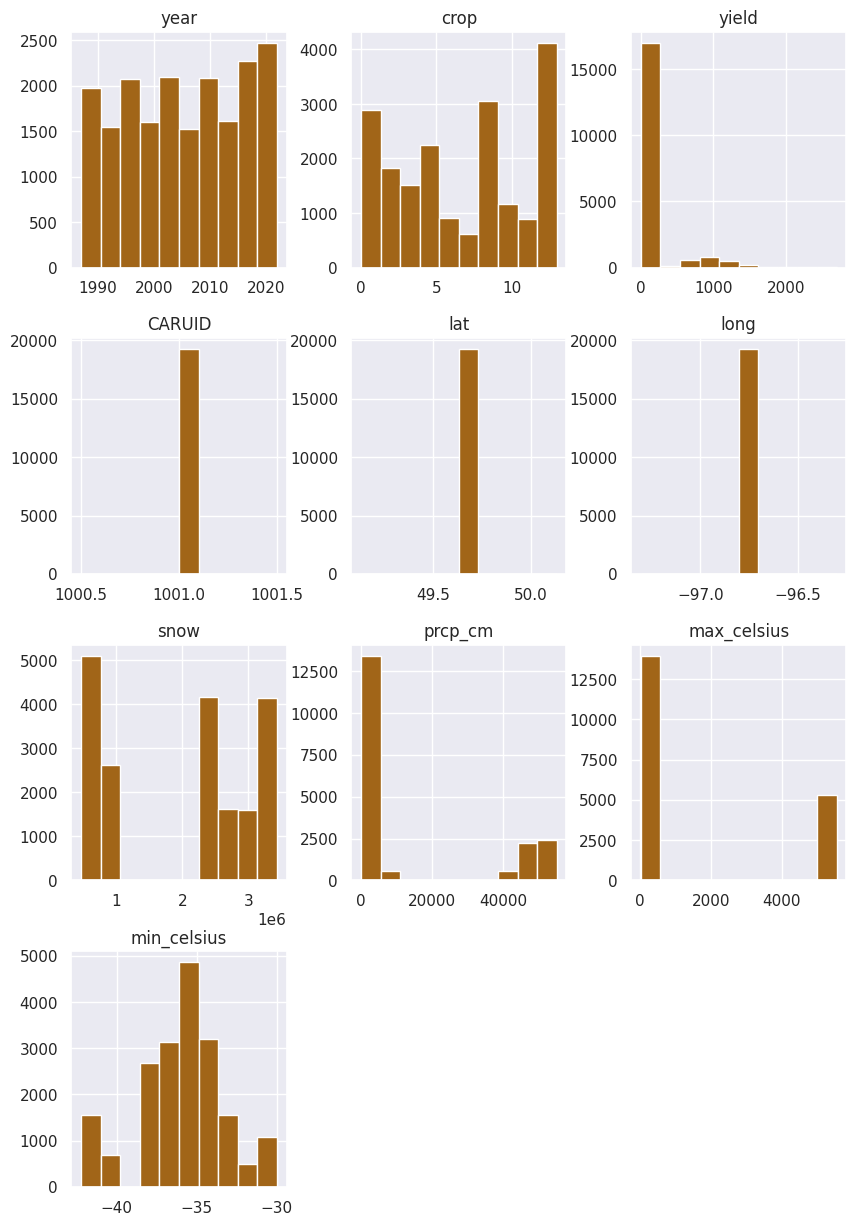

In [ ]:
sns.set(palette='BrBG')
datacorr.hist(figsize=(10,15));

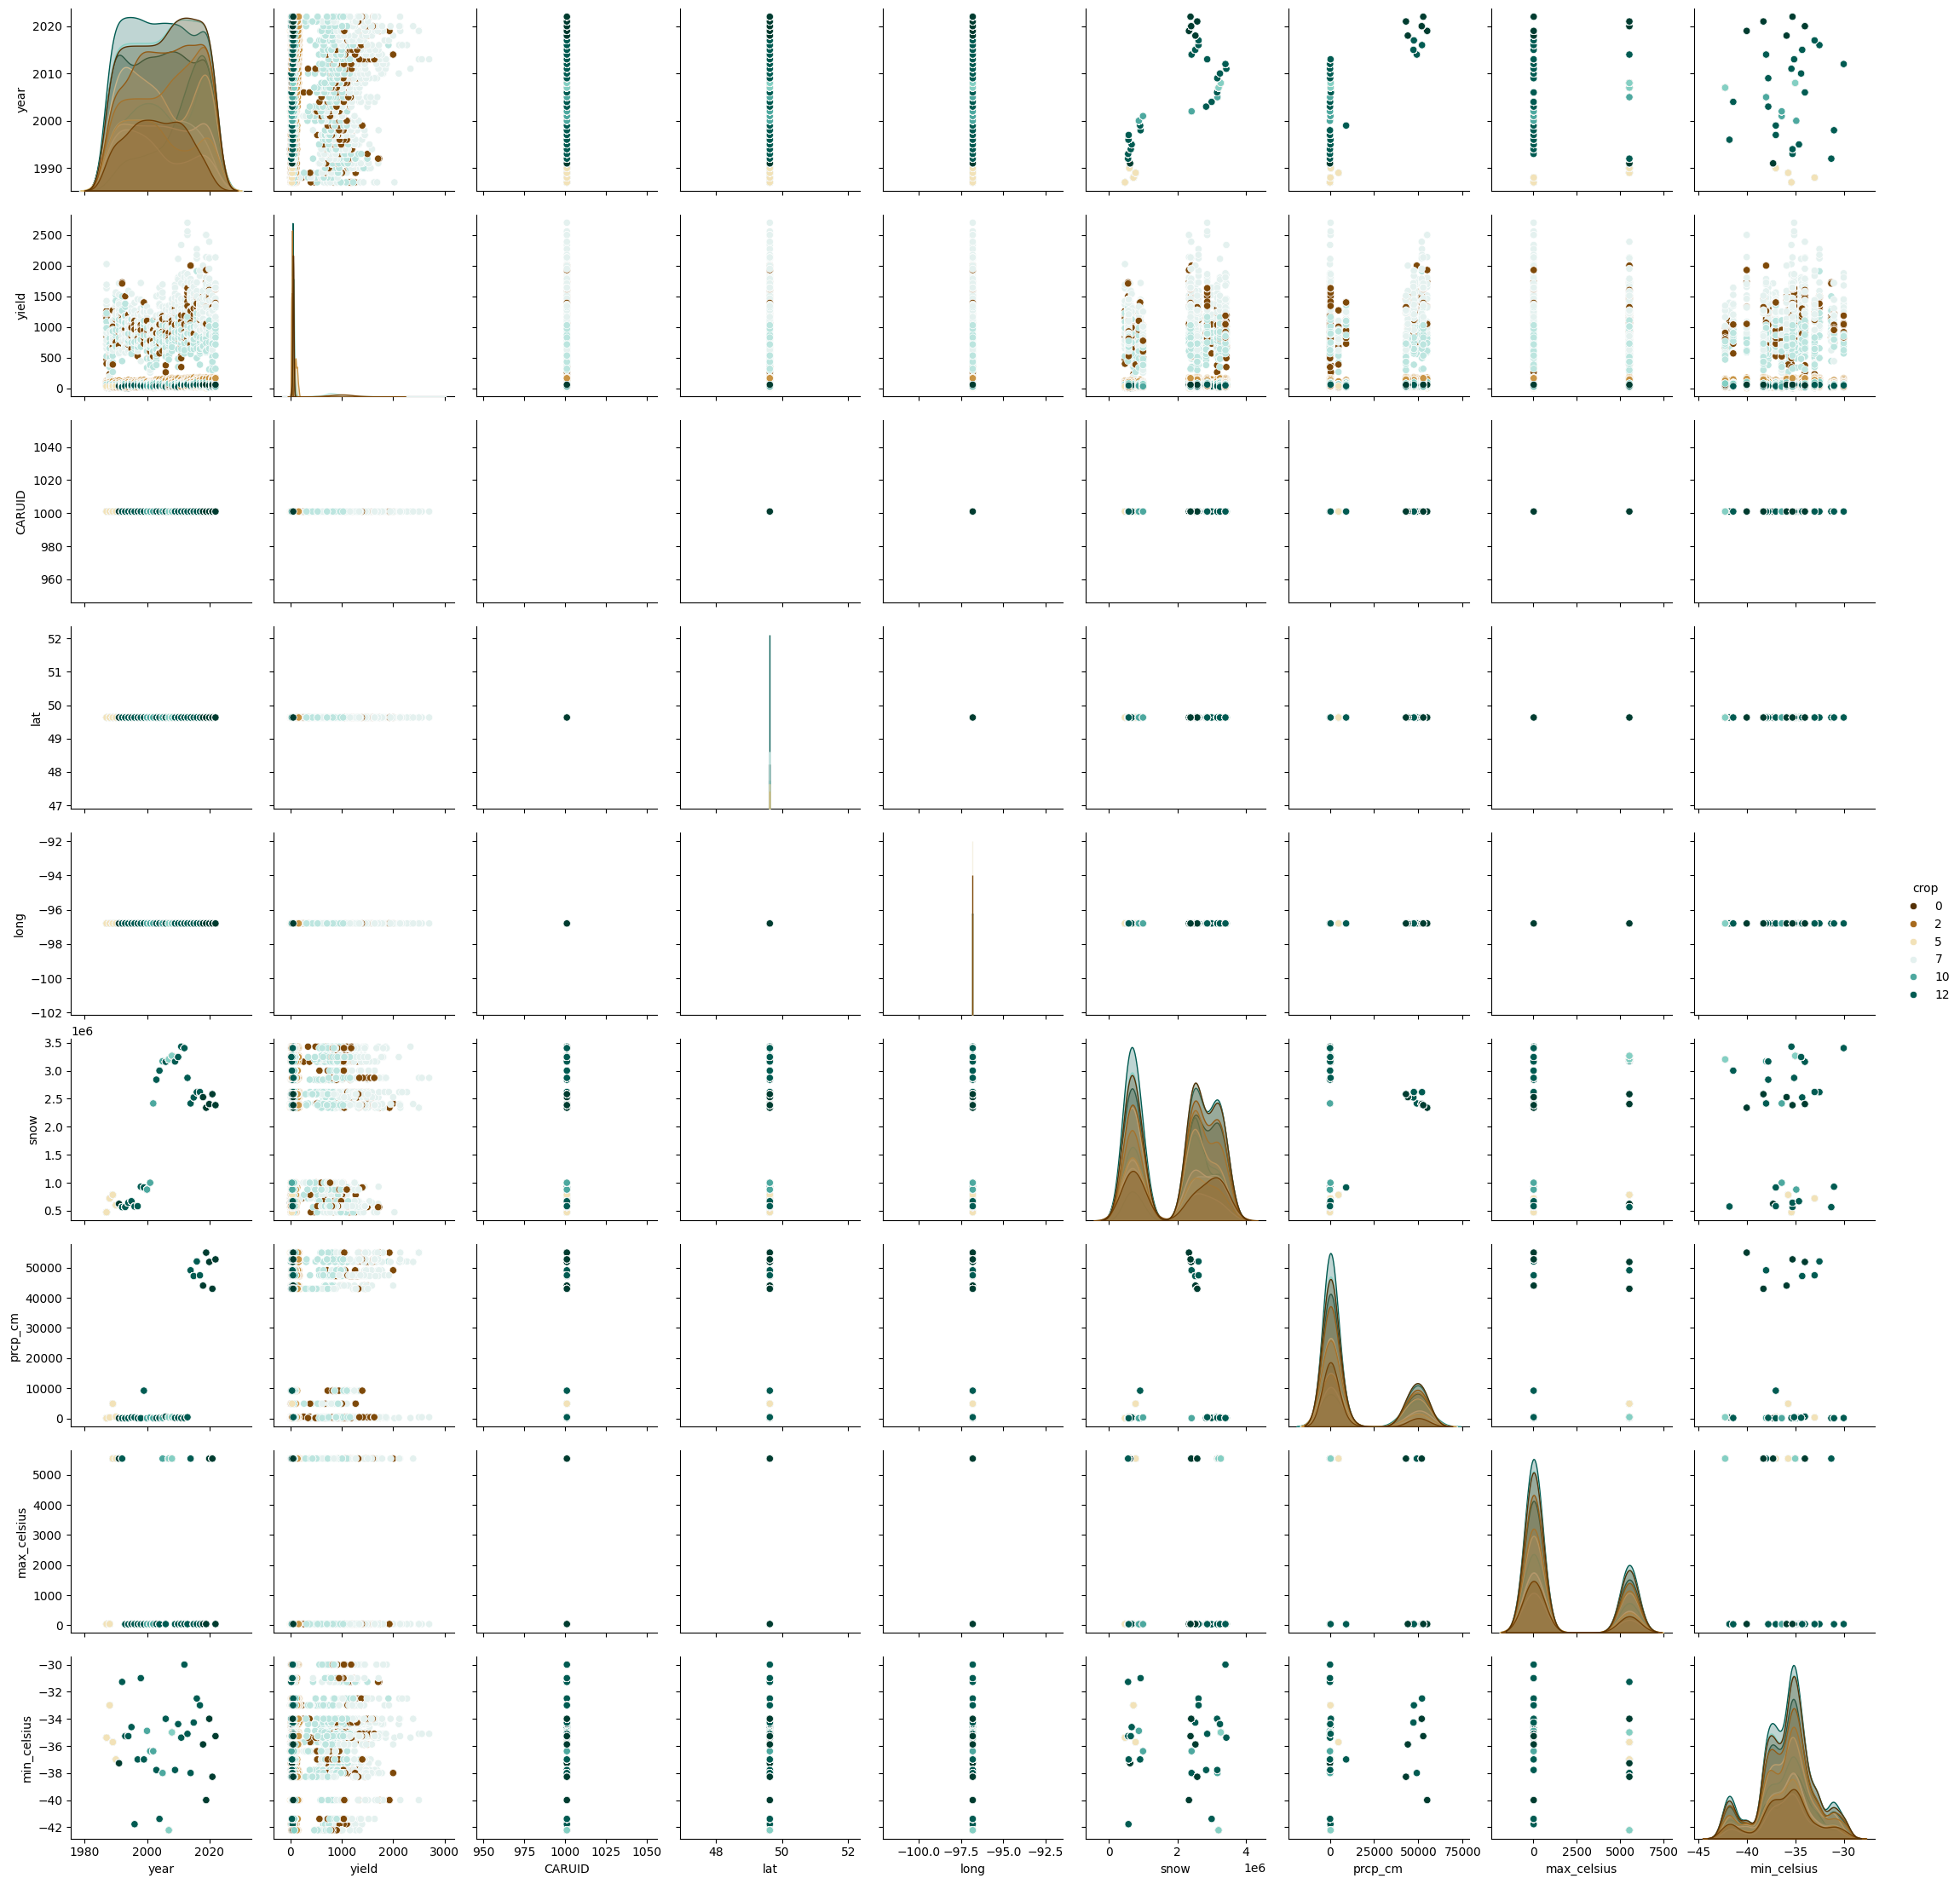

In [26]:
sns.pairplot(data=datacorr,hue='crop',kind='scatter',palette='BrBG')

# Machine Learning Model building and evaluation

Accuracy of Linear Regression Model Train is 1.60
Accuracy of the Linear Regression Model Test is 1.70


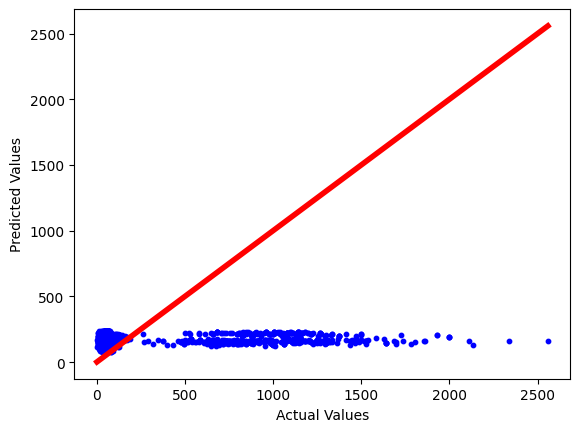

Accuracy of Decision Tree Model Train is 95.17
Accuracy of the Decision Tree Model Test is 95.16


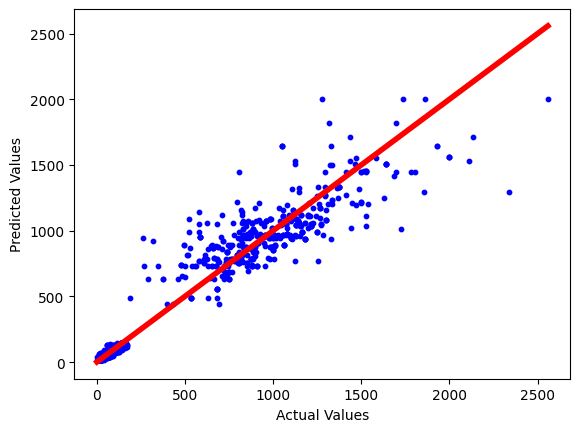

Accuracy of Random Forest Model Train is 95.16
Accuracy of the Random Forest Model Test is 95.14


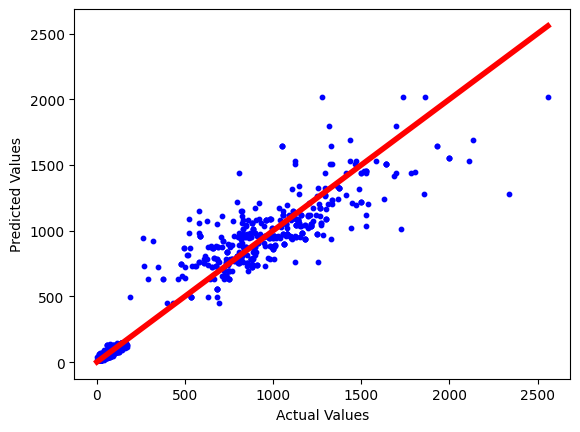

Accuracy of Gradient Boost Model Train is 92.80
Accuracy of the Gradient Boost Model Test is 92.67


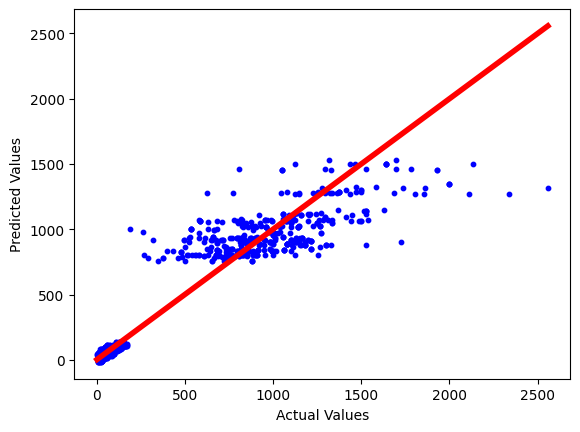

Accuracy of Bagging Regressor Model Train is 95.16
Accuracy of the Bagging Regressor Model Test is 95.14


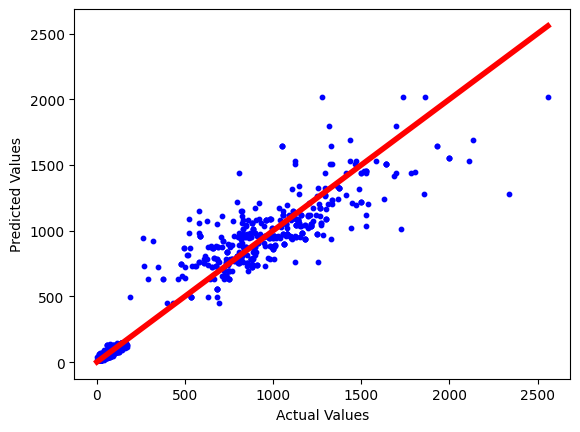

Accuracy of KNN Model Train is 93.86
Accuracy of the KNN Model Test is 93.17


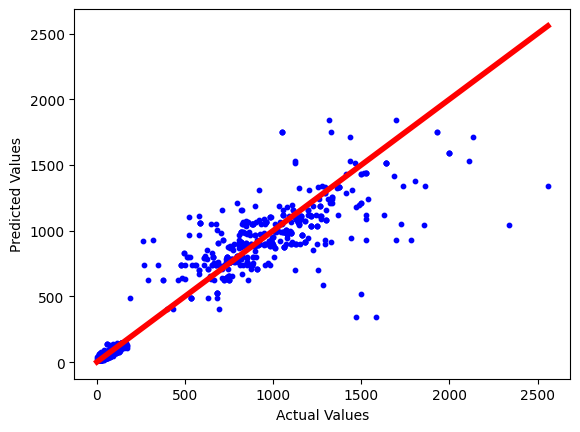

Accuracy of XGBoost Model Train is 95.17
Accuracy of the XGBoost Model Test is 95.17


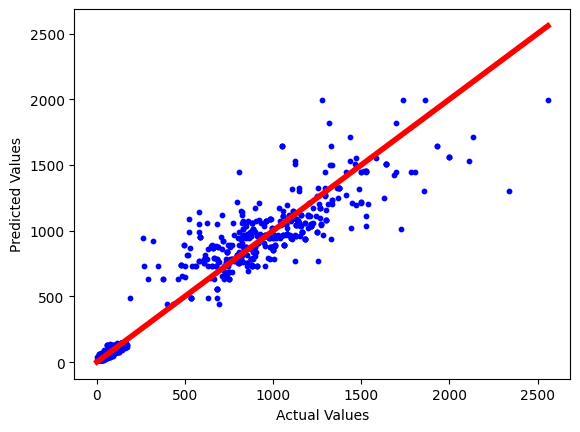

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

x, y = datacorr.drop(labels = 'yield', axis = 1), datacorr['yield']
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

#create a list of machine learning models
results = []

# List of machine learning models that will be trained
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state = 1)),
    ('Random Forest', RandomForestRegressor(random_state = 1)),
    ('Gradient Boost', GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 1)),
    ('Bagging Regressor', BaggingRegressor(n_estimators = 100, random_state = 1)),
    ('KNN', KNeighborsRegressor(n_neighbors = 10)),
    ('XGBoost', XGBRegressor(random_state = 1))]

# Loops through the list of machine learning models above
for name, model in models :
    # Train Model
    model.fit(x_train, y_train)
    # Make Predictions
    y_pred = model.predict(x_test)



    accuracy = model.score(x_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    # Add all metrics of model to a list
    results.append((name, accuracy, MSE, R2_score))

    acc = (model.score(x_train , y_train) * 100)
    print(f'Accuracy of {name} Model Train is {acc:.2f}')
    acc = (model.score(x_test , y_test) * 100)
    print(f'Accuracy of the {name} Model Test is {acc:.2f}')

    plt.scatter(y_test, y_pred,s=10,color='blue')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
#     plt.title(f' {name} Evaluation')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth = 4)
    plt.show()

# Comparing Models

In [ ]:
# Dataframe consisting of metrics of all the models
results_df = pd.DataFrame(results, columns = ['Model', 'Accuracy', 'MSE', 'R2_score'])
# Add red and green highlights in the dataframe to display best and worst performing models
results_format_df = results_df.style.highlight_max(subset = ['Accuracy', 'R2_score'], color = 'green').highlight_min(subset = ['MSE'], color = 'green').highlight_max(subset = ['MSE'], color = 'red').highlight_min(subset = ['Accuracy','R2_score'], color = 'red')
display(results_format_df)

,Model,Accuracy,MSE,R2_score
0,Linear Regression,0.016984,105814.234858,0.016984
1,Decision Tree,0.951628,5206.850143,0.951628
2,Random Forest,0.951394,5232.019086,0.951394
3,Gradient Boost,0.926664,7894.020481,0.926664
4,Bagging Regressor,0.951394,5232.029929,0.951394
5,KNN,0.931721,7349.690142,0.931721
6,XGBoost,0.951659,5203.552788,0.951659


# K-Fold Cross Validation

In [ ]:
results = []
fold_df = pd.DataFrame()

# Loops through the list of machine learning models
for name, model in models :
    # Train Model
    model.fit(x_train, y_train)
    # Make Predictions
    y_pred = model.predict(x_test)
    accuracy = model.score(x_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    # Add all metrics of model to a list
    results.append((name, accuracy, MSE, MAE, MAPE, R2_score))

    print(name)
    kf = KFold(n_splits = 10, shuffle = True)
    scores = cross_val_score(model, x, y, cv = kf)

    # Print out the CV Scores for each fold
    for fold, score in enumerate(scores) :
        print(f'Fold {fold + 1}: {score}')
        temp_df = pd.DataFrame({'Name' : name, 'Fold' : [fold + 1], 'Score' : [score]})
        dfs = [fold_df, temp_df]
        fold_df = pd.concat(dfs, ignore_index = True)

    # Print out the Mean CV scores for each model
    mean_score = np.mean(scores)
    print(f'Mean Score: {mean_score}')
    print('=' * 30)

Linear Regression
Fold 1: 0.016484469571041993
Fold 2: 0.011727144097200215
Fold 3: 0.01253861333233064
Fold 4: 0.015004791029489373
Fold 5: 0.02311293388744129
Fold 6: 0.011526298977455385
Fold 7: 0.008654254510277015
Fold 8: 0.01987863249664501
Fold 9: 0.011748321129707251
Fold 10: 0.01832097902334673
Mean Score: 0.01489964380549349
Decision Tree
Fold 1: 0.9366462111613661
Fold 2: 0.9365519052827447
Fold 3: 0.9510440344677633
Fold 4: 0.9426228811614941
Fold 5: 0.9491674090573162
Fold 6: 0.9483950432348872
Fold 7: 0.952097914176122
Fold 8: 0.9472099871573183
Fold 9: 0.9477958045431397
Fold 10: 0.9494796412499782
Mean Score: 0.9461010831492128
Random Forest
Fold 1: 0.9505826403612104
Fold 2: 0.9521721530773597
Fold 3: 0.9543442519722081
Fold 4: 0.9333803586887323
Fold 5: 0.9405107674793031
Fold 6: 0.9419780145310426
Fold 7: 0.9479615680027602
Fold 8: 0.9511076167107526
Fold 9: 0.943093806740938
Fold 10: 0.9487765108033872
Mean Score: 0.9463907688367694
Gradient Boost
Fold 1: 0.92288872

# Predict the yield of crops in 2024

- Below I have created predictions for crop yields in
year 2024 based on weather data taken form crop yield data csv.
- Used XGBoost for Regression as the prediction model.

In [ ]:
# Read a the crop yield csv which contains climate data for year 2023 and 2024 to use for the predictions

crop_predict_2024 = pd.read_csv("crop_yield_details.csv")
# Get rows where year equal to 2024 to a dataframe to create predictions for 2024

df_2024 = crop_predict_2024[crop_predict_2024['year'] == 2024]

# Covert long and lat colums of unique_car_df to float

unique_car_df['lat'] = unique_car_df['lat'].astype(float)
unique_car_df['long'] = unique_car_df['long'].astype(float)

# Iterate through df_2024 and get the lat and long, then see if there is a row with long and lat is in unique_car_df , then get the CARUID of the row and insert to CARUID of  df_2024 row

for index, row in df_2024.iterrows():
    lat = row['lat']
    long = row['long']
    # Check if there is a row with long and lat in unique_car_df
    match = unique_car_df[(unique_car_df['long'] == long) & (unique_car_df['lat'] == lat)]
    if not match.empty:
        # Get the CARUID of the matching row
        car_id = match['CARUID'].values[0]
        # Insert the CARUID into the CARUID of df_2024 row
        df_2024.loc[index, 'CARUID'] = car_id

df_2024.head()

,year,crop,yield,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius
36289,2024,NaN,NaN,1001.0,49.630005,-96.804104,1.181488e+06,27456.7904,25.000000,-30.000000
36327,2024,NaN,NaN,1002.0,45.386570,-73.300047,1.067162e+08,570743.1562,5537.722222,-50.500000
36365,2024,NaN,NaN,1003.0,50.226467,-97.245956,1.865040e+06,27470.6842,25.000000,-30.777778
36399,2024,NaN,NaN,1101.0,50.927772,-119.506680,1.300729e+05,27.1018,22.277778,-29.777778
36437,2024,NaN,NaN,1102.0,51.087729,-115.179280,1.080944e+06,37.9984,24.222222,-45.277778


In [ ]:
# Convert CARUID column to int  in df_2024

df_2024['CARUID'] = df_2024['CARUID'].astype(int)

# Using df_2024 remove CARUID and yield columns to use for the prediction model

df_2024.drop(columns=[ 'yield'], inplace=True)


# Create an empty dataframe to store the predicted yields
df_predicted_yields = pd.DataFrame(columns=['year', 'crop', 'CARUID', 'lat', 'long', 'snow', 'prcp_cm', 'max_celsius', 'min_celsius'])

# Loop through each row in df_2024
for index, row in df_2024.iterrows():
    # Create a new row with the same values as the current row
    new_row = row.copy()

    # Run a nested loop from 0 to 13 (inclusive)
    for i in range(0, 14):
        # Add the current index to the 'crop' column
        new_row['crop'] = i

        # Append the new row to the dataframe
        df_predicted_yields = df_predicted_yields._append(new_row, ignore_index=True)

# Display the predicted yields dataframe
print(df_predicted_yields.head())


# Change year, CARUID and crop column data to int

df_predicted_yields['CARUID'] = df_predicted_yields['CARUID'].astype(int)

df_predicted_yields['year'] = df_predicted_yields['year'].astype(int)
df_predicted_yields['crop'] = df_predicted_yields['crop'].astype(int)
df_predicted_yields.info()

   year crop CARUID        lat       long         snow     prcp_cm  \
0  2024    0   1001  49.630005 -96.804104  1181488.366  27456.7904   
1  2024    1   1001  49.630005 -96.804104  1181488.366  27456.7904   
2  2024    2   1001  49.630005 -96.804104  1181488.366  27456.7904   
3  2024    3   1001  49.630005 -96.804104  1181488.366  27456.7904   
4  2024    4   1001  49.630005 -96.804104  1181488.366  27456.7904   

   max_celsius  min_celsius  
0         25.0        -30.0  
1         25.0        -30.0  
2         25.0        -30.0  
3         25.0        -30.0  
4         25.0        -30.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         784 non-null    int64  
 1   crop         784 non-null    int64  
 2   CARUID       784 non-null    int64  
 3   lat          784 non-null    float64
 4   long         784 non-null    float64
 

Do the predictions usinf the XGBoost machine learning algorithm

In [ ]:
# Given the model and x variales predict the y variable

y_pred = model.predict(df_predicted_yields)

print(len(y_pred))

784


Add the predictions to the dataframe with climate and CARUID for year 2024

In [ ]:
# Add a new column to df_predcted_yields and add y_pred value to each row by looping through df_predicted_yields

df_predicted_yields['pred_yield'] = 0

for i in range(len(df_predicted_yields)):
  df_predicted_yields['pred_yield'][i] = y_pred[i]


# ------Change the encoded values of crop to crop names-------
#df_predicted_yields.head()
# Get the decoded categorical names of the crop column equal to the encoded value

# Get the unique encoded values for the crop column
encoded_crops = df_predicted_yields['crop'].unique()

# Create a dictionary to map encoded values to decoded names
crop_names_map = {}
for encoded_crop in encoded_crops:
    # Get the decoded name for the current encoded value
    decoded_name = label_encoder.inverse_transform([encoded_crop])[0]
    # Store the mapping in the dictionary
    crop_names_map[encoded_crop] = decoded_name

# Get the decoded names for the crop column
decoded_crop_names = [crop_names_map[crop] for crop in df_predicted_yields['crop']]

# Replace the encoded values with the decoded names in the DataFrame
df_predicted_yields['crop'] = decoded_crop_names
df_predicted_yields


,year,crop,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius,pred_yield
0,2024,barley,1001,49.630005,-96.804104,1181488.366,27456.7904,25.000000,-30.000000,64.068718
1,2024,canary_seed,1001,49.630005,-96.804104,1181488.366,27456.7904,25.000000,-30.000000,1337.010620
2,2024,canola,1001,49.630005,-96.804104,1181488.366,27456.7904,25.000000,-30.000000,41.199448
3,2024,corn,1001,49.630005,-96.804104,1181488.366,27456.7904,25.000000,-30.000000,145.080826
4,2024,durum_wheat,1001,49.630005,-96.804104,1181488.366,27456.7904,25.000000,-30.000000,41.692661
...,...,...,...,...,...,...,...,...,...,...
779,2024,oats,6201,53.853018,-125.257578,444597.282,13.0302,20.611111,-33.777778,76.500618
780,2024,peas,6201,53.853018,-125.257578,444597.282,13.0302,20.611111,-33.777778,40.669952
781,2024,soybeans,6201,53.853018,-125.257578,444597.282,13.0302,20.611111,-33.777778,34.941730
782,2024,spring_wheat,6201,53.853018,-125.257578,444597.282,13.0302,20.611111,-33.777778,52.225365


#Create dataset for GIS

Dataset used to get the geometry based on CARUID's -

https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm

In [ ]:
# Read a shp file

import geopandas as gpd

# Read the shapefile
CARUID_shapefiles_df = gpd.read_file('CARUID_shapefiles/lcar000b16a_e.shp')
# Convert the CRS to EPSG:4326
CARUID_shapefiles_df = CARUID_shapefiles_df.to_crs(epsg=4326)


##Create a geojson file

Convert the multipolygons to polygons.
 - First select the multipolygons and polygons.
 - Then convert the multipolygons to polygons.
 - Add all the polygons to the geometry column by concatenating
 - Then convert to a geojson file

In [ ]:
from shapely.geometry import Polygon

# Select the raws with mutipolygon type
multi = CARUID_shapefiles_df[CARUID_shapefiles_df['geometry'].type == 'MultiPolygon']
poli = CARUID_shapefiles_df[CARUID_shapefiles_df['geometry'].type == 'Polygon']

test_tab = multi[['CARUID', 'geometry','PRNAME']]
test_tab.reset_index(inplace=True)
test_tab2 = poli[['CARUID', 'geometry' ,'PRNAME' ]]
test_tab2.reset_index(inplace=True)

test_tab['geometry']= [Polygon(list(test_tab['geometry'][i].geoms)[0].exterior) for i in range(len(test_tab))]

test_tab = pd.concat([test_tab, test_tab2])
test_tab.set_index('CARUID',inplace = True)
test_tab.drop(columns=['index'], axis=1, inplace=True)

#Get the province names
province_names = test_tab['PRNAME'].unique().tolist()

# Get he unique crop names in df_predicted_yields

crop_names = df_predicted_yields['crop'].unique().tolist()


In [ ]:
crop_names

['barley',
 'canary_seed',
 'canola',
 'corn',
 'durum_wheat',
 'fall_rye',
 'flaxseed',
 'lentils',
 'mustard',
 'oats',
 'peas',
 'soybeans',
 'spring_wheat',
 'winter_wheat']

In [ ]:
#function to create geojson based on CARUIDs related to each province
def provinceGeojson(provinceName):
  sk_tab = test_tab[test_tab['PRNAME']== provinceName]['geometry']
  sk_tab.to_file( provinceName.split(' ')[0] +'.geojson', driver='GeoJSON')


These gejson files are already created. DO NOT RUN BELOW BLOCK unless any changes to the gejson files are needed.

In [ ]:
#loop through the province list to create geojson
for province in province_names:
  print(province)
  provinceGeojson(province)



Newfoundland and Labrador / Terre-Neuve-et-Labrador
Prince Edward Island / Île-du-Prince-Édouard
Nova Scotia / Nouvelle-Écosse
New Brunswick / Nouveau-Brunswick
Quebec / Québec
Ontario
Manitoba
British Columbia / Colombie-Britannique
Yukon
Northwest Territories / Territoires du Nord-Ouest
Nunavut
Saskatchewan
Alberta


#GIS Analysis

Add a crop name and a province name to view a map of the predicted yields.

In [ ]:
import geopandas as gpd
import geodatasets
import folium
import matplotlib.pyplot as plt
import branca.colormap as cm
import json

def createMaps(crop_name,provinceName):
  #create a dictionary for yield
  crop_df = df_predicted_yields[df_predicted_yields['crop'] == crop_name]
  crop_predict = crop_df[['CARUID','pred_yield']]
  crop_predict.set_index('CARUID', inplace = True)
  crop_dict = crop_predict.to_dict()

  #get the geojson based on the province name
  with open(provinceName.split(' ')[0] +'.geojson') as f:
    geo_json_data = json.load(f)

  #create the colour maps
  colormap = cm.LinearColormap(colors=['brown', 'yellow', 'green'], vmin=crop_predict['pred_yield'].min(), vmax=crop_predict['pred_yield'].max())


  def color_map_2(feature):
      if int(feature["properties"]["CARUID"]) in crop_dict["pred_yield"]:
          return colormap(crop_dict['pred_yield'][int(feature["properties"]["CARUID"])])
      else:
          return "red"

  #Create the folium map

  m = folium.Map([56.130, -106.35], zoom_start= 3, tiles='CartoDB positron')





  folium.GeoJson(
      geo_json_data,
      style_function=lambda feature: {
          "fillColor":color_map_2(feature),
          "color": "black",
          "weight": 0.5,
          "fillOpacity" : 0.9,
          "opacity": 0.5,

      },

  ).add_to(m)

    # Add color map legend
  colormap.caption = 'Predicted Yield'
  m.add_child(colormap)

  return m

In [ ]:
map = createMaps('spring_wheat','Nova Scotia / Nouvelle-Écosse')
map

###Explanation about the GIS vizualization

There is a grey area in CARUID = 4601 in oats Manitoba.
Let's explore the reason for the grey area.

- First let's take the data row where CARUID == 4602 which shows red colour.
- We can notice a data row present.


In [ ]:
df_predicted_yields[(df_predicted_yields['CARUID'] == 4602) & (df_predicted_yields['crop'] == 'oats')]


,year,crop,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius,pred_yield
401,2024,oats,4602,47.636374,-72.933776,12124.182,43.3324,5537.722222,-29.722222,73.891884


- Now let's explore the grey area where the CARUID == 4601
- We can observe that there no data oats where CARUID == 4601
- Conclusion is missing data is the reason for the grey area

In [ ]:
df_predicted_yields[(df_predicted_yields['CARUID'] == 4601) & (df_predicted_yields['crop'] == 'oats')]

,year,crop,CARUID,lat,long,snow,prcp_cm,max_celsius,min_celsius,pred_yield


#Interactive geospacial vizualization of predicted crop yield based on the provinces

Below is the helper code to add colormap to LayerControl

In [ ]:
from branca.element import MacroElement

from jinja2 import Template

class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)  # noqa

##Crop yield prediction of 14 crop in Alberta

In [ ]:
import geopandas as gpd
import folium
import branca.colormap as cm
import json



# Create the folium map
m1 = folium.Map([56.130, -106.35], zoom_start=3, tiles='CartoDB positron')

def createMaps(crop_name, provinceName):
    # Create a dictionary for yield
    crop_df = df_predicted_yields[df_predicted_yields['crop'] == crop_name]
    crop_predict = crop_df[['CARUID','pred_yield']]
    crop_predict.set_index('CARUID', inplace=True)
    crop_dict = crop_predict.to_dict()

    # Load the GeoJSON based on the province name
    with open(provinceName.split(' ')[0] + '.geojson') as f:
        geo_json_data = json.load(f)

    # Create the colour map
    colormap = cm.LinearColormap(colors=['red', 'yellow', 'green'], vmin=crop_predict['pred_yield'].min(), vmax=crop_predict['pred_yield'].max())

    def color_map_2(feature):
        if int(feature["properties"]["CARUID"]) in crop_dict["pred_yield"]:
            return colormap(crop_dict['pred_yield'][int(feature["properties"]["CARUID"])])
        else:
            return "transparent"

    # Add tooltips to display the details
    tooltip = folium.GeoJsonTooltip(
        fields=["CARUID"],
        aliases=["CARUID:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )

    # Create a FeatureGroup
    fg = folium.FeatureGroup(name=f'{crop_name} - {provinceName}', overlay=True, show=False)

    # Add GeoJson layer to the FeatureGroup
    folium.GeoJson(
        geo_json_data,
        style_function=lambda feature: {
            "fillColor": color_map_2(feature),
            "color": "black",
            "fillOpacity": 0.4,
        },
        tooltip=tooltip
    ).add_to(fg)

    # Add colormap legend to the FeatureGroup
    colormap.caption = 'Predicted Yield'


    #colormap.add_to(fg)

    return fg,colormap


count = 0
for crop in crop_names:
  #for prov in province_names:

    new_name = f"fg_{count}"


    # Call createMaps function for each crop and province
    new_name,colormap1 = createMaps(crop, 'Alberta')


    # Add FeatureGroups to the map
    m1.add_child(new_name)
    m1.add_child(colormap1)
    m1.add_child(BindColormap(new_name, colormap1))
    #colormap1.add_to(m)

    count +=1

# Add LayerControl to the map
folium.LayerControl().add_to(m1)



m1


##Crop yield prediction of 14 crop in Manitoba

In [ ]:
import geopandas as gpd
import folium
import branca.colormap as cm
import json



# Create the folium map
m = folium.Map([56.130, -106.35], zoom_start=3, tiles='CartoDB positron')

def createMaps(crop_name, provinceName):
    # Create a dictionary for yield
    crop_df = df_predicted_yields[df_predicted_yields['crop'] == crop_name]
    crop_predict = crop_df[['CARUID','pred_yield']]
    crop_predict.set_index('CARUID', inplace=True)
    crop_dict = crop_predict.to_dict()

    # Load the GeoJSON based on the province name
    with open(provinceName.split(' ')[0] + '.geojson') as f:
        geo_json_data = json.load(f)

    # Create the colour map
    colormap = cm.LinearColormap(colors=['red', 'yellow', 'green'], vmin=crop_predict['pred_yield'].min(), vmax=crop_predict['pred_yield'].max())

    def color_map_2(feature):
        if int(feature["properties"]["CARUID"]) in crop_dict["pred_yield"]:
            return colormap(crop_dict['pred_yield'][int(feature["properties"]["CARUID"])])
        else:
            return "transparent"

    # Add tooltips to display the details
    tooltip = folium.GeoJsonTooltip(
        fields=["CARUID"],
        aliases=["CARUID:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )

    # Create a FeatureGroup
    fg = folium.FeatureGroup(name=f'{crop_name} - {provinceName}', overlay=True, show=False)

    # Add GeoJson layer to the FeatureGroup
    folium.GeoJson(
        geo_json_data,
        style_function=lambda feature: {
            "fillColor": color_map_2(feature),
            "color": "black",
            "fillOpacity": 0.4,
        },
        tooltip=tooltip
    ).add_to(fg)

    # Add colormap legend to the FeatureGroup
    colormap.caption = 'Predicted Yield'


    #colormap.add_to(fg)

    return fg,colormap


count = 0
for crop in crop_names:
  #for prov in province_names:

    new_name = f"fg_{count}"


    # Call createMaps function for each crop and province
    new_name,colormap1 = createMaps(crop, 'Manitoba')


    # Add FeatureGroups to the map
    m.add_child(new_name)
    m.add_child(colormap1)
    m.add_child(BindColormap(new_name, colormap1))
    #colormap1.add_to(m)

    count +=1

# Add LayerControl to the map
folium.LayerControl(collapsed = False).add_to(m)

#m.save("manitoba.html")

m


In [ ]:
import geopandas as gpd
import folium
import branca.colormap as cm
import json



# Create the folium map
m = folium.Map([56.130, -106.35], zoom_start=3, tiles='CartoDB positron')

def createMaps(crop_name, provinceName):
    # Create a dictionary for yield
    crop_df = df_predicted_yields[df_predicted_yields['crop'] == crop_name]
    crop_predict = crop_df[['CARUID','pred_yield']]
    crop_predict.set_index('CARUID', inplace=True)
    crop_dict = crop_predict.to_dict()

    # Load the GeoJSON based on the province name
    with open(provinceName.split(' ')[0] + '.geojson') as f:
        geo_json_data = json.load(f)

    # Create the colour map
    colormap = cm.LinearColormap(colors=['red', 'yellow', 'green'], vmin=crop_predict['pred_yield'].min(), vmax=crop_predict['pred_yield'].max(),caption=f'{crop_name} - {provinceName}',)

    def color_map_2(feature):
        if int(feature["properties"]["CARUID"]) in crop_dict["pred_yield"]:
            return colormap(crop_dict['pred_yield'][int(feature["properties"]["CARUID"])])
        else:
            return "transparent"

    # Add tooltips to display the details
    tooltip = folium.GeoJsonTooltip(
        fields=["CARUID"],
        aliases=["CARUID:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )

    # Create a FeatureGroup
    fg = folium.FeatureGroup(name=f'{crop_name} - {provinceName}', overlay=True, show=False)

    # Add GeoJson layer to the FeatureGroup
    folium.GeoJson(
        geo_json_data,
        style_function=lambda feature: {
            "fillColor": color_map_2(feature),
            "color": "black",
            "fillOpacity": 0.4,
        },
        tooltip=tooltip
    ).add_to(fg)




    #colormap.add_to(fg)

    return fg,colormap



crop_names1 = [
 'canola',
 'corn',
 ]
province_names1 = ['Manitoba','Saskatchewan','Alberta']

count = 0
for crop in crop_names1:
  for prov in province_names1:

    new_name = f"fg_{count}"


    # Call createMaps function for each crop and province
    new_name,colormap1 = createMaps(crop, prov)


    # Add FeatureGroups to the map
    m.add_child(new_name)
    m.add_child(colormap1)
    m.add_child(BindColormap(new_name, colormap1))
    #colormap1.add_to(m)

    count +=1

# Add LayerControl to the map
folium.LayerControl(collapsed = False).add_to(m)

m.save("yield_of_3_provinces.html")

m
